In [2]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230218)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

from sklearn import linear_model

In [3]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

In [4]:
# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

In [5]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [6]:
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

In [7]:
class Backtest:
    def __init__(self,data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        print(f"Cummulative return is: {res:.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")

    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        print(f"Max Drawdown: {res:.2f}%")
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        print(f"Sharpe Ratio: {res:.3f}")

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        print(f"Strategy CAGR is: {CAGR:.2f}%")
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Asset Return")
        ax.legend(["Asset Cumm Return","Strategy Cumm Return (Adj)"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
        self.calculate_cumm_return()
        self.calculate_cagr()
        self.calculate_max_drawdown()
        self.calculate_sharpe_ratio()
        self.plot_backtest_buy_sell()
        self.plot_backtest_returns()

In [8]:
MLStrategy_data = pdr.get_data_yahoo(['SPY','^VIX','CL=F'],start="2004-11-1", end="2023-11-1")

[*********************100%***********************]  3 of 3 completed


In [9]:
MLStrategy_data

Adj Close                             Close              \
                 CL=F         SPY       ^VIX       CL=F         SPY   
Date                                                                  
2004-11-01  50.130001   78.617935  16.270000  50.130001  113.510002   
2004-11-02  49.619999   78.645645  16.180000  49.619999  113.550003   
2004-11-03  50.880001   79.636047  14.040000  50.880001  114.980003   
2004-11-04  48.820000   80.723457  13.970000  48.820000  116.550003   
2004-11-05  49.610001   81.229080  13.840000  49.610001  117.279999   
...               ...         ...        ...        ...         ...   
2023-10-25  85.389999  417.549988  20.190001  85.389999  417.549988   
2023-10-26  83.209999  412.549988  20.680000  83.209999  412.549988   
2023-10-27  85.540001  410.679993  21.270000  85.540001  410.679993   
2023-10-30  82.309998  415.589996  19.750000  82.309998  415.589996   
2023-10-31  81.019997  418.200012  18.139999  81.019997  418.200012   

                            High                               Low  \
                 ^VIX       CL=F         SPY       ^VIX       CL=F   
Date                                                                 
2004-11-01  16.270000  52.500000  113.839996  16.760000  49.150002   
2004-11-02  16.180000  50.419998  114.570000  16.320000  49.549999   
2004-11-03  14.040000  51.200001  115.360001  15.180000  48.650002   
2004-11-04  13.970000  51.060001  116.669998  14.020000  48.770000   
2004-11-05  13.840000  49.700001  117.639999  14.100000  48.299999   
...               ...        ...         ...        ...        ...   
2023-10-25  20.190001  85.559998  421.920013  21.240000  82.080002   
2023-10-26  20.680000  85.589996  417.329987  21.959999  82.559998   
2023-10-27  21.270000  85.900002  414.600006  22.070000  83.099998   
2023-10-30  19.750000  85.300003  416.679993  21.160000  81.820000   
2023-10-31  18.139999  83.370003  418.529999  19.860001  80.739998   

                                        Open                           Volume  \
                   SPY       ^VIX       CL=F         SPY       ^VIX      CL=F   
Date                                                                            
2004-11-01  113.199997  16.180000  51.820000  113.559998  16.430000  133138.0   
2004-11-02  113.220001  15.210000  50.189999  113.669998  15.990000   82754.0   
2004-11-03  114.239998  13.790000  49.610001  115.029999  15.050000  143701.0   
2004-11-04  114.680000  12.950000  50.880001  114.779999  13.830000  121094.0   
2004-11-05  116.489998  13.230000  48.810001  117.050003  13.670000  115766.0   
...                ...        ...        ...         ...        ...       ...   
2023-10-25  417.019989  18.860001  83.690002  421.890015  19.389999  429459.0   
2023-10-26  411.600006  20.219999  85.370003  416.450012  21.780001  341792.0   
2023-10-27  409.209991  19.719999  83.529999  414.190002  20.389999  333760.0   
2023-10-30  412.220001  19.549999  85.000000  413.559998  21.129999  356928.0   
2023-10-31  414.209991  17.969999  82.589996  416.179993  19.860001  346007.0   

                              
                    SPY ^VIX  
Date                          
2004-11-01   36720900.0  0.0  
2004-11-02   56210000.0  0.0  
2004-11-03   76960200.0  0.0  
2004-11-04   55350300.0  0.0  
2004-11-05   63287200.0  0.0  
...                 ...  ...  
2023-10-25   94223200.0  0.0  
2023-10-26  115156800.0  0.0  
2023-10-27  107367700.0  0.0  
2023-10-30   86562700.0  0.0  
2023-10-31   79665200.0  0.0  

[4785 rows x 18 columns]

<Axes: xlabel='Date'>

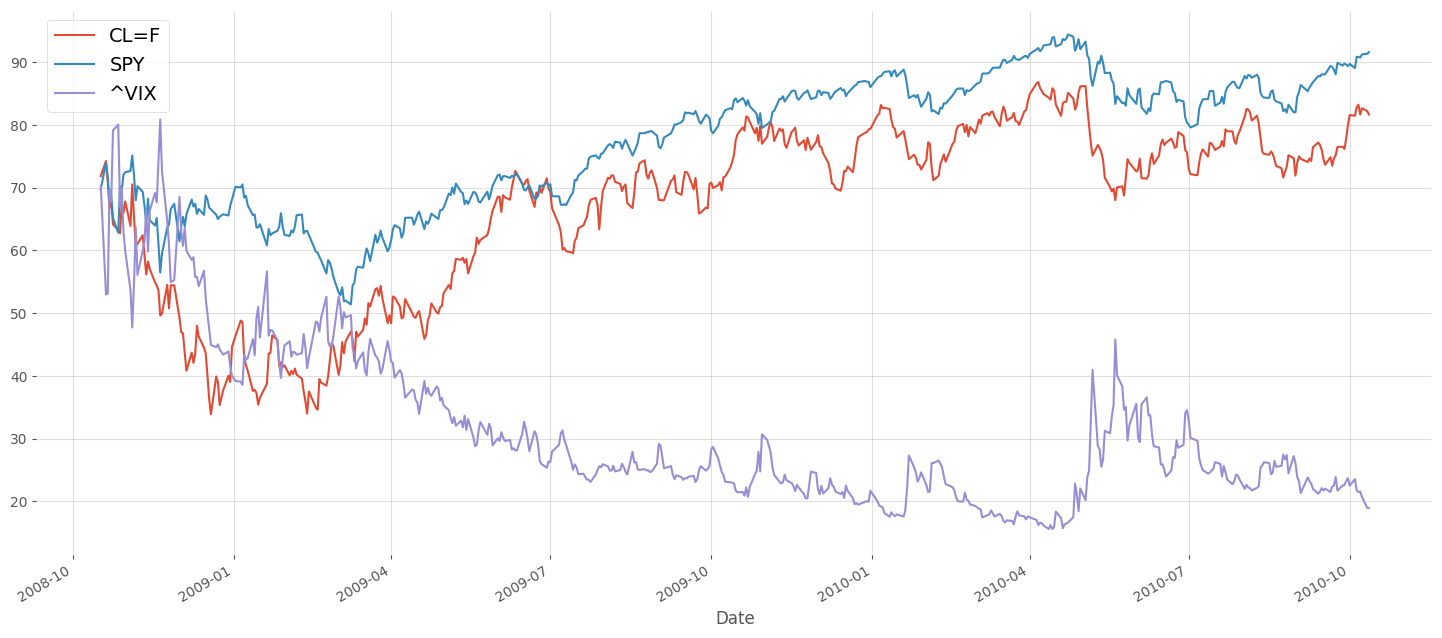

In [10]:
MLStrategy_data.loc[:,('Adj Close',)].iloc[1000:1500].plot(figsize=[18,8])

In [9]:
return_period=1
Y =\
    (np
     .log(MLStrategy_data.loc[ : , ("Adj Close", "SPY")]
         )
     .diff(return_period)
     .shift(-return_period)
    )
Y

Date
2004-11-01    0.000352
2004-11-02    0.012515
2004-11-03    0.013562
2004-11-04    0.006244
2004-11-05   -0.001450
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: (Adj Close, SPY), Length: 4785, dtype: float64

In [10]:
Y.name =\
    (Y
     .name[-1]
     +
     "_pred")

Y

Date
2004-11-01    0.000352
2004-11-02    0.012515
2004-11-03    0.013562
2004-11-04    0.006244
2004-11-05   -0.001450
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: SPY_pred, Length: 4785, dtype: float64

In [11]:
X1=\
(
    MLStrategy_data.loc[ : , ("Adj Close", "^VIX")]
#    .pct_change(return_period)
)

X1.name='VIX_pctchange'

In [12]:
X1

Date
2004-11-01    16.270000
2004-11-02    16.180000
2004-11-03    14.040000
2004-11-04    13.970000
2004-11-05    13.840000
                ...    
2023-10-25    20.190001
2023-10-26    20.680000
2023-10-27    21.270000
2023-10-30    19.750000
2023-10-31    18.139999
Name: VIX_pctchange, Length: 4785, dtype: float64

In [13]:
X2=\
(
    MLStrategy_data.loc[ : , ("Adj Close", "CL=F")]
#    .pct_change(return_period)
)

X2.name='CL_pct_change'

In [14]:
X=\
(
    pd
    .concat([X1,X2],
            axis = 1)
)

X

,VIX_pctchange,CL_pct_change
Date,,
2004-11-01,16.270000,50.130001
2004-11-02,16.180000,49.619999
2004-11-03,14.040000,50.880001
2004-11-04,13.970000,48.820000
2004-11-05,13.840000,49.610001
...,...,...
2023-10-25,20.190001,85.389999
2023-10-26,20.680000,83.209999
2023-10-27,21.270000,85.540001


In [15]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

data

,SPY_pred,VIX_pctchange,CL_pct_change
Date,,,
2004-11-01,0.000352,16.270000,50.130001
2004-11-02,0.012515,16.180000,49.619999
2004-11-03,0.013562,14.040000,50.880001
2004-11-04,0.006244,13.970000,48.820000
2004-11-05,-0.001450,13.840000,49.610001
...,...,...,...
2023-10-24,-0.014456,18.969999,83.739998
2023-10-25,-0.012047,20.190001,85.389999
2023-10-26,-0.004543,20.680000,83.209999


In [16]:
data.describe()

,SPY_pred,VIX_pctchange,CL_pct_change
count,4773.000000,4773.000000,4773.000000
mean,0.000360,19.347683,71.416761
std,0.012180,8.943916,22.089513
min,-0.115887,9.140000,-37.630001
25%,-0.004066,13.350000,53.590000
50%,0.000669,16.879999,69.260002
75%,0.005796,22.540001,89.050003
max,0.135577,82.690002,145.289993


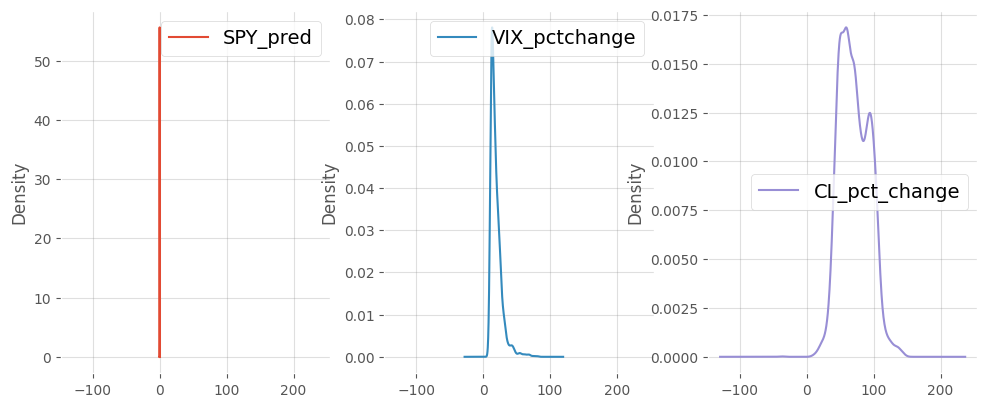

In [17]:
(
    data.
    plot(kind = "density",
         subplots = True,
         layout = (3, 4),
         sharex = True,
         legend = True,
         figsize = [16, 16]
        )
)

plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

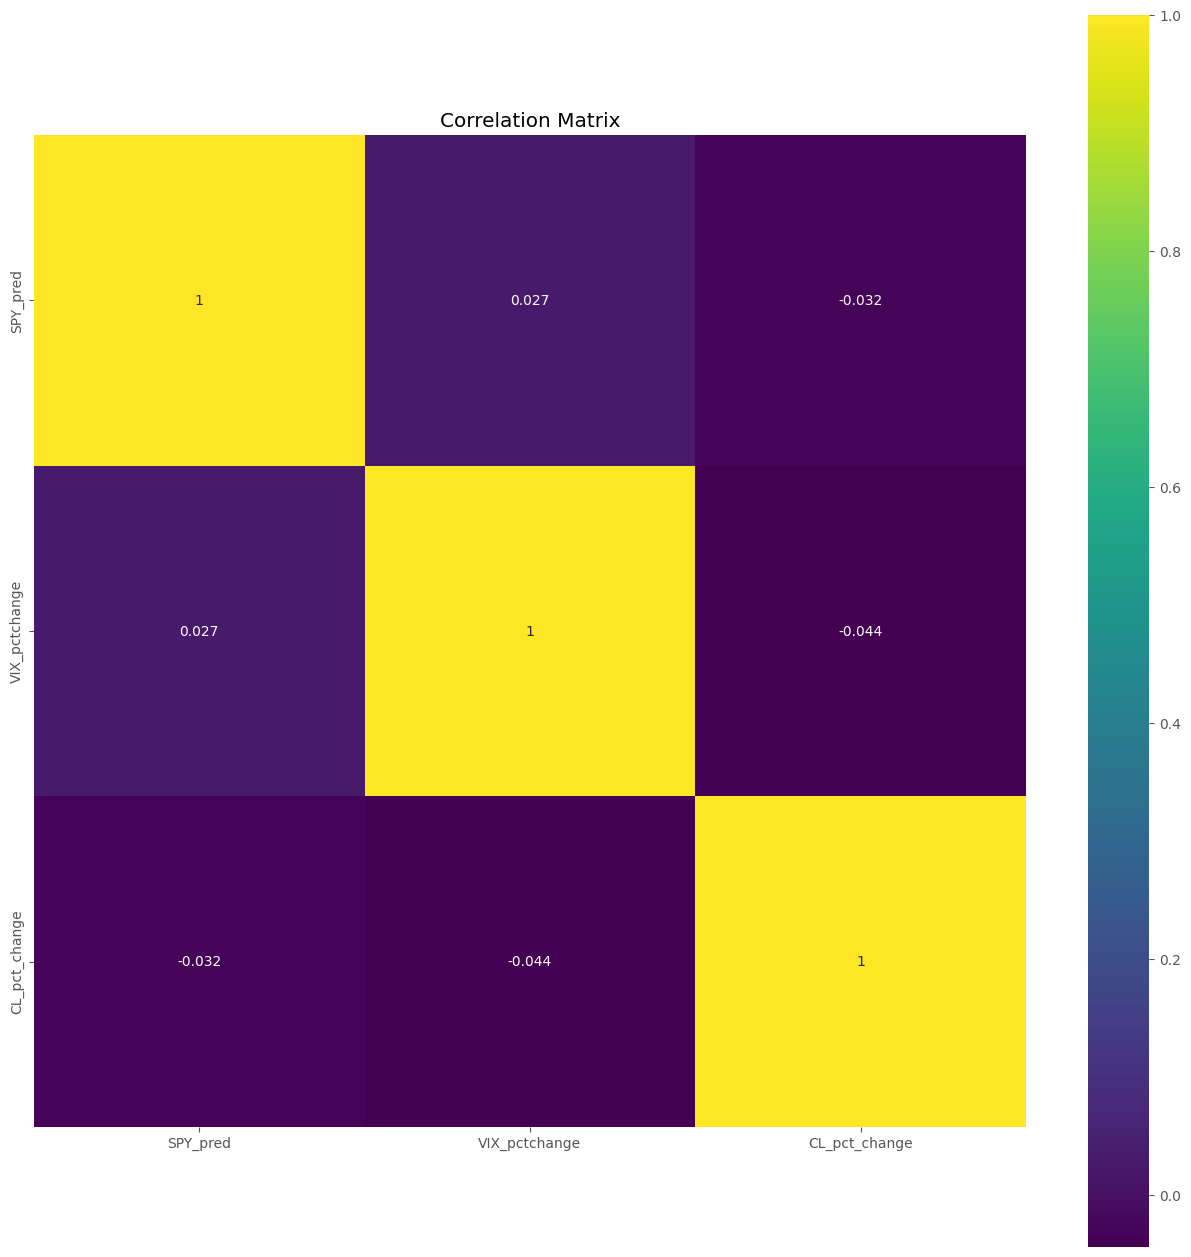

In [18]:
correlation = data.corr()

plt.figure(figsize =[16, 16]
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            cmap = "viridis",
            annot = True)

In [19]:
Y = data.loc[ : , Y.name]

Y

Date
2004-11-01    0.000352
2004-11-02    0.012515
2004-11-03    0.013562
2004-11-04    0.006244
2004-11-05   -0.001450
                ...   
2023-10-24   -0.014456
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
Name: SPY_pred, Length: 4773, dtype: float64

In [20]:
X = data.loc[ : , X.columns]

X

,VIX_pctchange,CL_pct_change
Date,,
2004-11-01,16.270000,50.130001
2004-11-02,16.180000,49.619999
2004-11-03,14.040000,50.880001
2004-11-04,13.970000,48.820000
2004-11-05,13.840000,49.610001
...,...,...
2023-10-24,18.969999,83.739998
2023-10-25,20.190001,85.389999
2023-10-26,20.680000,83.209999


In [21]:
# M =\
#     linear_model \
#     .LogisticRegression(solver = "lbfgs",
#                         C = 1e7,
#                         multi_class = "auto",
#                         max_iter = 1000)

In [22]:
M =\
    linear_model \
    .LinearRegression()

In [23]:
M.fit(X,Y)

LinearRegression()

### Try new

In [24]:
np.sign(Y)

Date
2004-11-01    1.0
2004-11-02    1.0
2004-11-03    1.0
2004-11-04    1.0
2004-11-05   -1.0
             ... 
2023-10-24   -1.0
2023-10-25   -1.0
2023-10-26   -1.0
2023-10-27    1.0
2023-10-30    1.0
Name: SPY_pred, Length: 4773, dtype: float64

In [25]:
data

,SPY_pred,VIX_pctchange,CL_pct_change
Date,,,
2004-11-01,0.000352,16.270000,50.130001
2004-11-02,0.012515,16.180000,49.619999
2004-11-03,0.013562,14.040000,50.880001
2004-11-04,0.006244,13.970000,48.820000
2004-11-05,-0.001450,13.840000,49.610001
...,...,...,...
2023-10-24,-0.014456,18.969999,83.739998
2023-10-25,-0.012047,20.190001,85.389999
2023-10-26,-0.004543,20.680000,83.209999


In [26]:
data['Prediction']=np.sign(M.predict(X))

In [27]:
data['Prediction'].value_counts()

Prediction
 1.0    3814
-1.0     959
Name: count, dtype: int64

In [28]:
data

,SPY_pred,VIX_pctchange,CL_pct_change,Prediction
Date,,,,
2004-11-01,0.000352,16.270000,50.130001,1.0
2004-11-02,0.012515,16.180000,49.619999,1.0
2004-11-03,0.013562,14.040000,50.880001,1.0
2004-11-04,0.006244,13.970000,48.820000,1.0
2004-11-05,-0.001450,13.840000,49.610001,1.0
...,...,...,...,...
2023-10-24,-0.014456,18.969999,83.739998,1.0
2023-10-25,-0.012047,20.190001,85.389999,1.0
2023-10-26,-0.004543,20.680000,83.209999,1.0


In [29]:
ML_backtest_data=pd.concat([MLStrategy_data.loc[:,('Adj Close','SPY')],data['Prediction']],axis=1)

In [30]:
MLStrategy_data.loc[:,('Adj Close','SPY')]

Date
2004-11-01     78.617928
2004-11-02     78.645638
2004-11-03     79.636078
2004-11-04     80.723465
2004-11-05     81.229057
                 ...    
2023-10-25    417.549988
2023-10-26    412.549988
2023-10-27    410.679993
2023-10-30    415.589996
2023-10-31    418.200012
Name: (Adj Close, SPY), Length: 4785, dtype: float64

In [31]:
data['Prediction']

Date
2004-11-01    1.0
2004-11-02    1.0
2004-11-03    1.0
2004-11-04    1.0
2004-11-05    1.0
             ... 
2023-10-24    1.0
2023-10-25    1.0
2023-10-26    1.0
2023-10-27    1.0
2023-10-30    1.0
Name: Prediction, Length: 4773, dtype: float64

In [32]:
ML_backtest_data.columns=['Adj Close','Position']

In [33]:
ML_backtest_data=ML_backtest_data.fillna(method='ffill')
ML_backtest_data=ML_backtest_data.fillna(0)
ML_backtest_data

,Adj Close,Position
Date,,
2004-11-01,78.617928,1.0
2004-11-02,78.645638,1.0
2004-11-03,79.636078,1.0
2004-11-04,80.723465,1.0
2004-11-05,81.229057,1.0
...,...,...
2023-10-25,417.549988,1.0
2023-10-26,412.549988,1.0
2023-10-27,410.679993,1.0


Cummulative return is: 626.91% with final Account balance: $727166.8849832597
Strategy CAGR is: 11.00%
Max Drawdown: -45.23%
Sharpe Ratio: 0.638


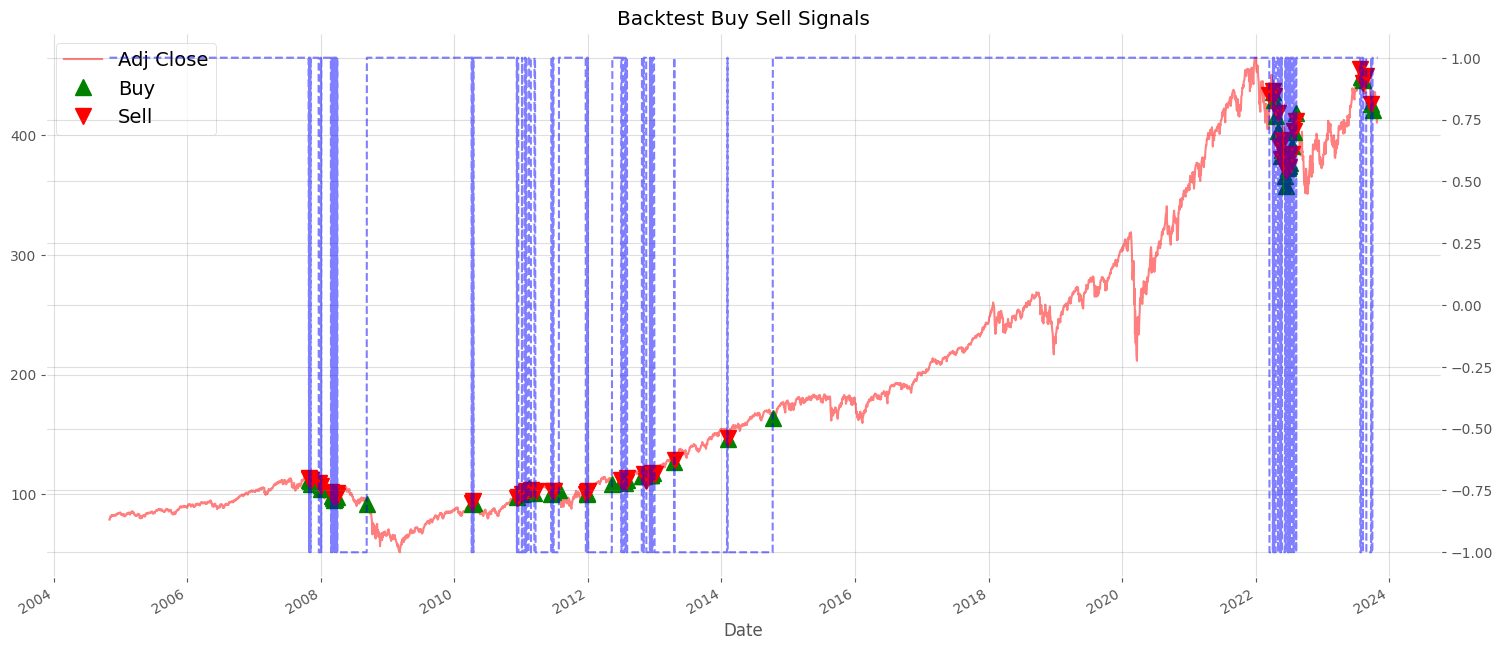

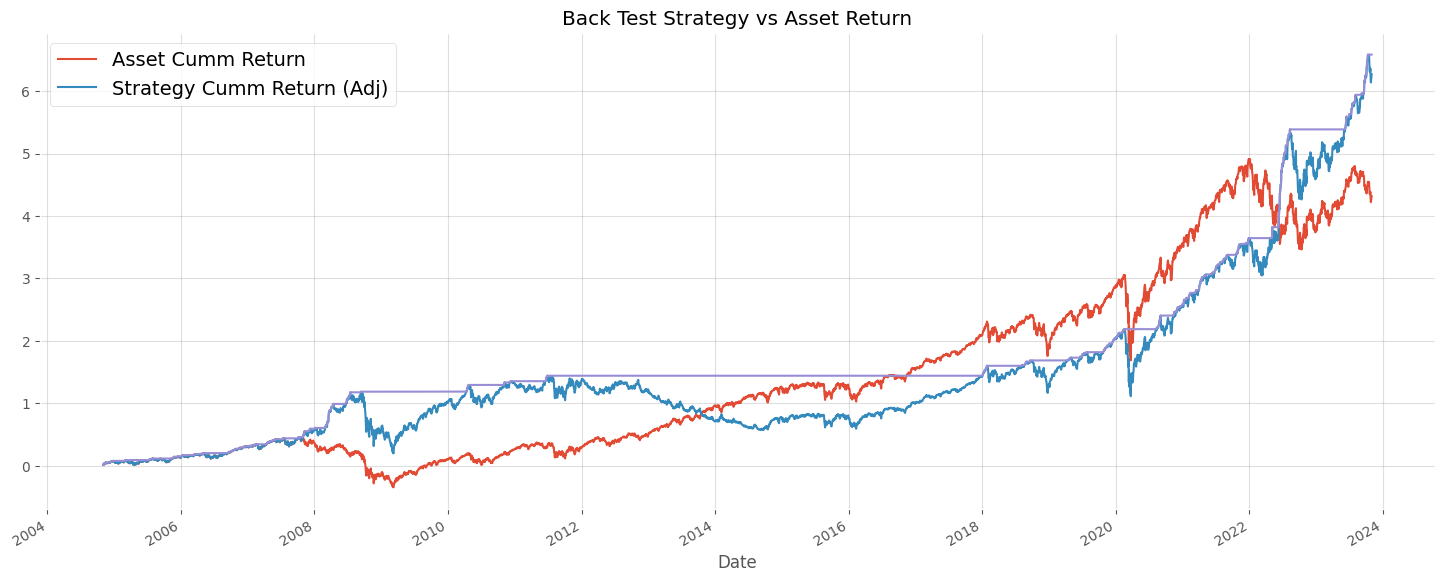

In [34]:
Backtest_ML1_Strategy=Backtest(ML_backtest_data,100000,0)
Backtest_ML1_Strategy.plot_all_stats()

In [35]:
ML_backtest_data

,Adj Close,Position,Buy_Sell,log_return,Strategy_return,Expense,Capital,Adj Capital,Adj return,drawdown
Date,,,,,,,,,,
2004-11-01,78.617928,1.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2004-11-02,78.645638,1.0,0.0,0.000352,0.000352,0,100035.246364,100035.246364,NaN,NaN
2004-11-03,79.636078,1.0,0.0,0.012515,0.012515,0,101295.061268,101295.061268,0.012515,0.000000
2004-11-04,80.723465,1.0,0.0,0.013562,0.013562,0,102678.189925,102678.189925,0.013562,0.000000
2004-11-05,81.229057,1.0,0.0,0.006244,0.006244,0,103321.290502,103321.290502,0.006244,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-10-25,417.549988,1.0,0.0,-0.014456,-0.014456,0,726036.621438,726036.621438,-0.014456,-0.043972
2023-10-26,412.549988,1.0,0.0,-0.012047,-0.012047,0,717342.613024,717342.613024,-0.012047,-0.056019
2023-10-27,410.679993,1.0,0.0,-0.004543,-0.004543,0,714091.062367,714091.062367,-0.004543,-0.060562


In [36]:
(15 ** (1/20)) -1

0.14499756464358904